# Multiple Linear Regression in Statsmodels - Lab

## Introduction
In this lab, you'll practice fitting a multiple linear regression model on our Boston Housing Data set!

## Objectives
You will be able to:
* Run linear regression on Boston Housing dataset with all the predictors
* Interpret the parameters of the multiple linear regression model

## The Boston Housing Data

We pre-processed the Boston Housing Data again. This time, however, we did things slightly different:
- We dropped "ZN" and "NOX" completely
- We categorized "RAD" in 3 bins and "TAX" in 4 bins
- We used min-max-scaling on "B", "CRIM" and "DIS" (and logtransformed all of them first, except "B")
- We used standardization on "AGE", "INDUS", "LSTAT" and "PTRATIO" (and logtransformed all of them first, except for "AGE") 

In [41]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_features = boston_features.drop(["NOX","ZN"],axis=1)

# first, create bins for based on the values observed. 3 values will result in 2 bins
bins = [0,6,  24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for based on the values observed. 4 values will result in 3 bins
bins = [0, 270, 360, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix="TAX", drop_first=1)
rad_dummy = pd.get_dummies(bins_rad, prefix="RAD", drop_first=1)
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)

In [42]:
age = boston_features["AGE"]
b = boston_features["B"]
logcrim = np.log(boston_features["CRIM"])
logdis = np.log(boston_features["DIS"])
logindus = np.log(boston_features["INDUS"])
loglstat = np.log(boston_features["LSTAT"])
logptratio = np.log(boston_features["PTRATIO"])

# minmax scaling
boston_features["B"] = (b-min(b))/(max(b)-min(b))
boston_features["CRIM"] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features["DIS"] = (logdis-min(logdis))/(max(logdis)-min(logdis))

#standardization
boston_features["AGE"] = (age-np.mean(age))/np.sqrt(np.var(age))
boston_features["INDUS"] = (logindus-np.mean(logindus))/np.sqrt(np.var(logindus))
boston_features["LSTAT"] = (loglstat-np.mean(loglstat))/np.sqrt(np.var(loglstat))
boston_features["PTRATIO"] = (logptratio-np.mean(logptratio))/(np.sqrt(np.var(logptratio)))


In [43]:
boston_features.sample(5)

,CRIM,INDUS,CHAS,RM,AGE,DIS,PTRATIO,B,LSTAT,"RAD_(6, 24]","TAX_(270, 360]","TAX_(360, 712]"
36,0.286370,-0.483267,0.0,5.841,-0.255144,0.461503,0.376884,0.951233,0.105823,0,1,0
454,0.765960,0.947825,0.0,6.728,0.907687,0.334045,0.784047,0.016037,0.929694,1,0,1
402,0.766859,0.947825,0.0,6.404,1.117494,0.156822,0.784047,0.947577,1.066385,1,0,1
343,0.145744,-1.069888,0.0,6.696,-0.432946,0.684305,-0.320894,1.000000,-0.665780,0,0,1
128,0.412611,1.192754,0.0,6.431,1.074822,0.199215,1.171532,1.000000,0.604289,0,0,1


In [44]:
boston_features.shape

(506, 12)

In [45]:
boston_features.dtypes

CRIM              float64
INDUS             float64
CHAS              float64
RM                float64
AGE               float64
DIS               float64
PTRATIO           float64
B                 float64
LSTAT             float64
RAD_(6, 24]         uint8
TAX_(270, 360]      uint8
TAX_(360, 712]      uint8
dtype: object

In [46]:
boston_features.isnull().sum()

CRIM              0
INDUS             0
CHAS              0
RM                0
AGE               0
DIS               0
PTRATIO           0
B                 0
LSTAT             0
RAD_(6, 24]       0
TAX_(270, 360]    0
TAX_(360, 712]    0
dtype: int64

In [47]:
boston_features.describe()

,CRIM,INDUS,CHAS,RM,AGE,DIS,PTRATIO,B,LSTAT,"RAD_(6, 24]","TAX_(270, 360]","TAX_(360, 712]"
count,506.000000,5.060000e+02,506.000000,506.000000,5.060000e+02,506.000000,5.060000e+02,506.000000,5.060000e+02,506.000000,506.000000,506.000000
mean,0.448432,3.510587e-16,0.069170,6.284634,-1.474446e-16,0.449191,-2.878681e-15,0.898568,2.808469e-16,0.341897,0.343874,0.460474
std,0.226336,1.000990e+00,0.253994,0.702617,1.000990e+00,0.227318,1.000990e+00,0.230205,1.000990e+00,0.474815,0.475470,0.498929
min,0.000000,-3.783365e+00,0.000000,3.561000,-2.335437e+00,0.000000,-3.000989e+00,0.000000,-3.036568e+00,0.000000,0.000000,0.000000
25%,0.268367,-6.614858e-01,0.000000,5.885500,-8.374480e-01,0.261281,-4.125447e-01,0.945730,-7.200364e-01,0.000000,0.000000,0.000000
50%,0.387692,1.428756e-01,0.000000,6.208500,3.173816e-01,0.439687,3.139590e-01,0.986232,9.850402e-02,0.000000,0.000000,0.000000
75%,0.666445,9.478254e-01,0.000000,6.623500,9.067981e-01,0.642307,7.840469e-01,0.998298,7.656165e-01,1.000000,1.000000,1.000000
max,1.000000,1.497881e+00,1.000000,8.780000,1.117494e+00,1.000000,1.468580e+00,1.000000,2.108674e+00,1.000000,1.000000,1.000000


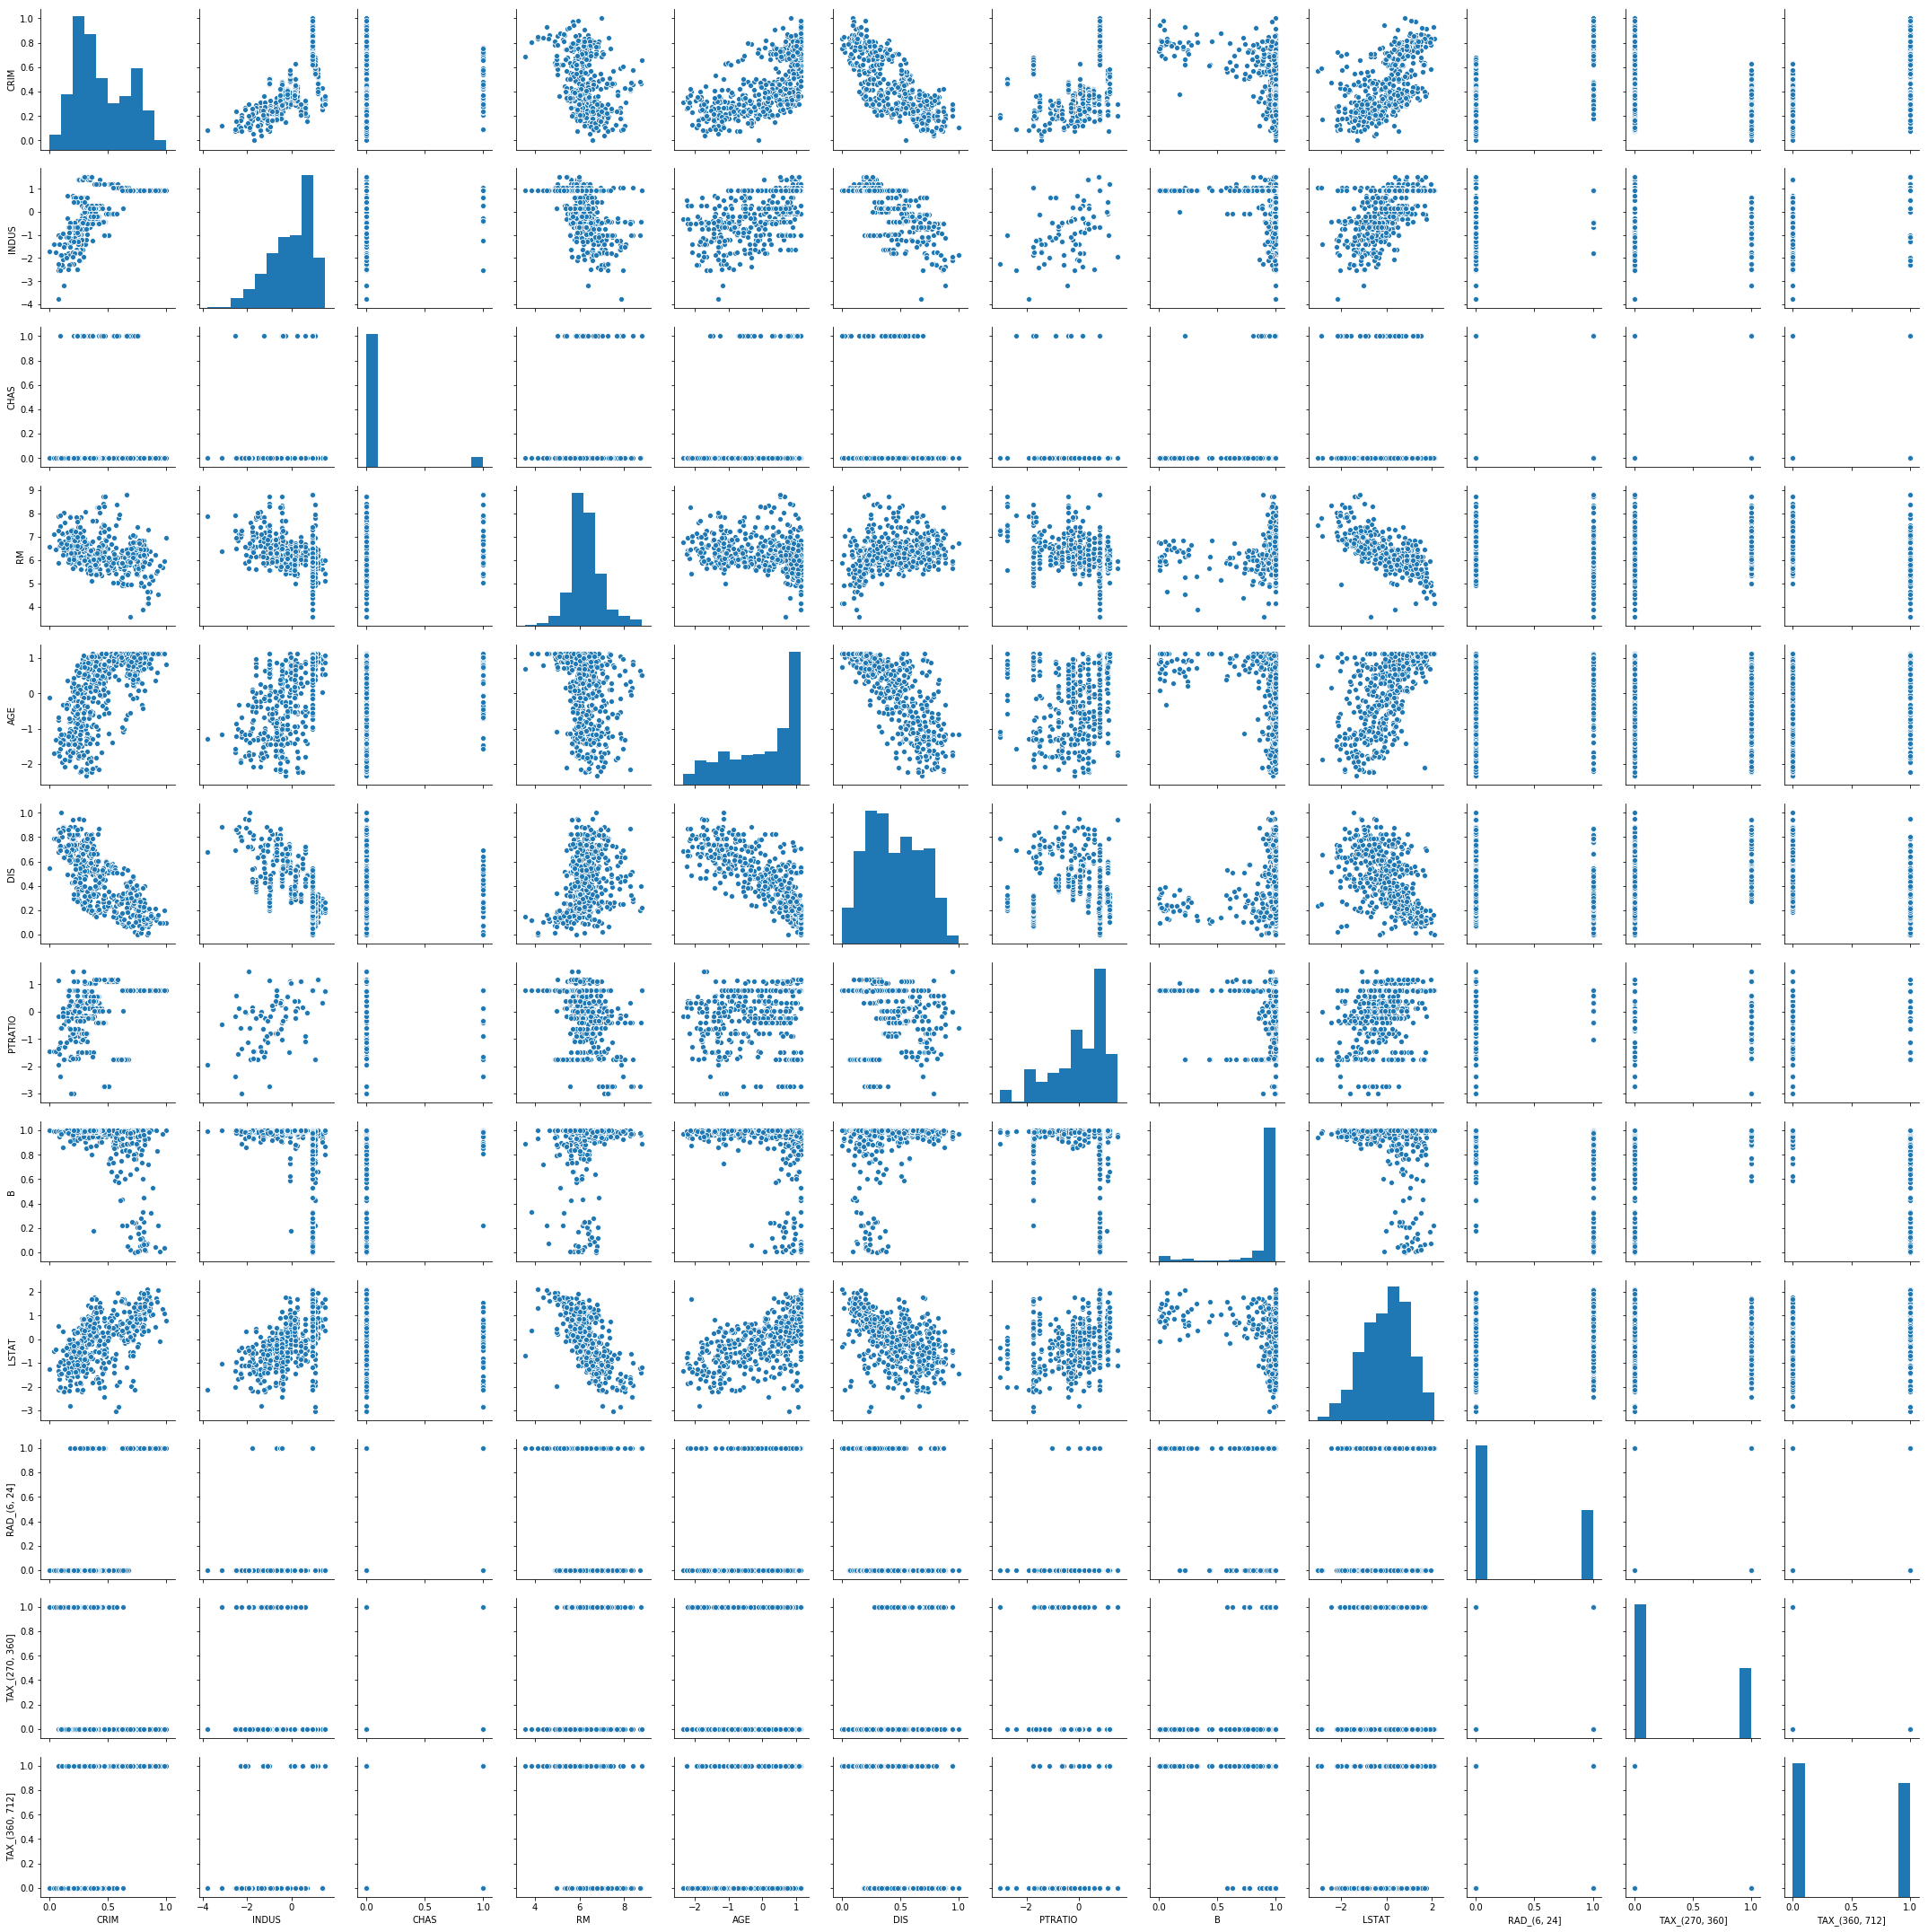

In [48]:
import seaborn as sns
sns.pairplot(boston_features)

In [49]:
boston_target = pd.DataFrame(boston['target'], columns=['price'])

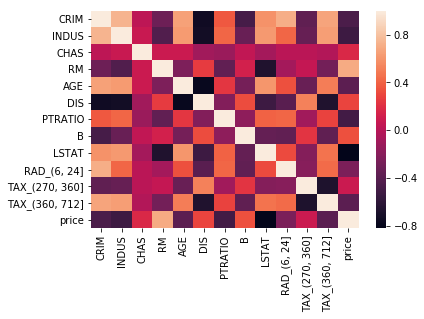

In [50]:
sns.heatmap(pd.concat([boston_features,boston_target], axis=1).corr())

In [51]:
pd.concat([boston_features,boston_target], axis=1).corr()['price']

CRIM             -0.454302
INDUS            -0.519270
CHAS              0.175260
RM                0.695360
AGE              -0.376955
DIS               0.292316
PTRATIO          -0.503160
B                 0.333461
LSTAT            -0.815442
RAD_(6, 24]      -0.246441
TAX_(270, 360]    0.091468
TAX_(360, 712]   -0.384692
price             1.000000
Name: price, dtype: float64

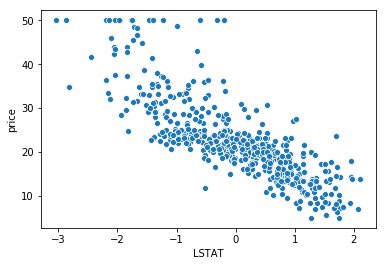

In [52]:
sns.scatterplot(boston_features['LSTAT'],boston_target['price'])

## Run a single linear model in Statsmodels

In [53]:
X = boston_features['LSTAT']
y = boston_target['price']

In [54]:
import statsmodels.api as sm
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1000.
Date:                Fri, 03 May 2019   Prob (F-statistic):          9.28e-122
Time:                        15:15:19   Log-Likelihood:                -1563.6
No. Observations:                 506   AIC:                             3131.
Df Residuals:                     504   BIC:                             3140.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.237     95.116      0.000      22.067      22.998
LSTAT         -7.4923      0.237    -31.627      0.000      -7.958      -7.027
==============================================================================
Omnibus:                      126.181   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.855
Skew:                           1.237   Prob(JB):                     4.74e-71
Kurtosis:                       6.039   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

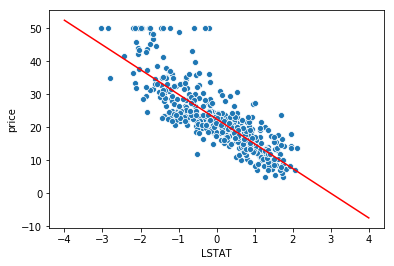

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.scatterplot(boston_features['LSTAT'],boston_target['price'], ax=ax)
line_x = np.linspace(-4,4,100)
line_y = model.params[0] + model.params[1]*line_x
sns.lineplot(line_x,line_y, color='red', ax=ax)


## Run a multiple linear model in Statsmodels

In [56]:
X = boston_features
y = boston_target['price']

In [57]:
import statsmodels.api as sm
X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     144.9
Date:                Fri, 03 May 2019   Prob (F-statistic):          5.08e-153
Time:                        15:15:19   Log-Likelihood:                -1458.2
No. Observations:                 506   AIC:                             2942.
Df Residuals:                     493   BIC:                             2997.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.6442      3.189      2.711      0.007       2.379      14.910
CRIM              -1.9538      2.115     -0.924      0.356      -6.110       2.202
INDUS             -0.8046      0.362     -2.220      0.027      -1.517      -0.093
CHAS               2.5959      0.796      3.260      0.001       1.032       4.160
RM                 2.6466      0.408      6.488      0.000       1.845       3.448
AGE                0.0794      0.352      0.226      0.821      -0.612       0.770
DIS              -10.0962      1.856     -5.439      0.000     -13.743      -6.449
PTRATIO           -1.4867      0.241     -6.160      0.000      -1.961      -1.013
B                  3.8412      0.986      3.897      0.000       1.905       5.778
LSTAT             -5.6288      0.354    -15.912      0.000      -6.324      -4.934
RAD_(6, 24]        1.3380      0.672      1.990      0.047       0.017       2.659
TAX_(270, 360]    -1.2598      0.600     -2.100      0.036      -2.438      -0.081
TAX_(360, 712]    -2.1461      0.704     -3.047      0.002      -3.530      -0.762
==============================================================================
Omnibus:                      106.730   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.101
Skew:                           0.891   Prob(JB):                     1.48e-94
Kurtosis:                       7.162   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpret the coefficients for PTRATIO, LSTAT

- CRIM: per capita crime rate by town
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per $10,000
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: % lower status of the population

## Predict the house price given the following characteristics (before manipulation!!)

Make sure to transform your variables as needed!

- CRIM: 0.15
- INDUS: 6.07
- CHAS: 1        
- RM:  6.1
- AGE: 33.2
- DIS: 7.6
- PTRATIO: 17
- B: 383
- LSTAT: 10.87
- RAD: 8
- TAX: 284

In [58]:
CRIM = 0.15
INDUS = 6.07
CHAS = 1        
RM = 6.1
AGE = 33.2
DIS = 7.6
PTRATIO = 17
B = 383
LSTAT = 10.87
RAD = 8
TAX = 284

In [59]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_features = boston_features.drop(["NOX","ZN"],axis=1)

In [60]:
boston_features.head()

,CRIM,INDUS,CHAS,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,2.31,0.0,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,7.07,0.0,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,7.07,0.0,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,2.18,0.0,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,2.18,0.0,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [61]:
# first, create bins for based on the values observed. 3 values will result in 2 bins
bins = [0,6,  24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for based on the values observed. 4 values will result in 3 bins
bins = [0, 270, 360, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix="TAX",drop_first=1)
rad_dummy = pd.get_dummies(bins_rad, prefix="RAD",drop_first=1)
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)

In [62]:
boston_features.head()

,CRIM,INDUS,CHAS,RM,AGE,DIS,PTRATIO,B,LSTAT,"RAD_(6, 24]","TAX_(270, 360]","TAX_(360, 712]"
0,0.00632,2.31,0.0,6.575,65.2,4.0900,15.3,396.90,4.98,0,1,0
1,0.02731,7.07,0.0,6.421,78.9,4.9671,17.8,396.90,9.14,0,0,0
2,0.02729,7.07,0.0,7.185,61.1,4.9671,17.8,392.83,4.03,0,0,0
3,0.03237,2.18,0.0,6.998,45.8,6.0622,18.7,394.63,2.94,0,0,0
4,0.06905,2.18,0.0,7.147,54.2,6.0622,18.7,396.90,5.33,0,0,0


In [63]:
age = boston_features["AGE"]
b = boston_features["B"]
logcrim = np.log(boston_features["CRIM"])
logdis = np.log(boston_features["DIS"])
logindus = np.log(boston_features["INDUS"])
loglstat = np.log(boston_features["LSTAT"])
logptratio = np.log(boston_features["PTRATIO"])

# minmax scaling
logB = (B-min(b))/(max(b)-min(b))
logCRIM = (np.log(CRIM)-min(logcrim))/(max(logcrim)-min(logcrim))
logDIS = (np.log(DIS)-min(logdis))/(max(logdis)-min(logdis))

#standardization
standAGE = (AGE-np.mean(age))/np.sqrt(np.var(age))
standINDUS = (np.log(INDUS)-np.mean(logindus))/np.sqrt(np.var(logindus))
standLSTAT = (np.log(LSTAT)-np.mean(loglstat))/np.sqrt(np.var(loglstat))
standPTRATIO = (np.log(PTRATIO)-np.mean(logptratio))/(np.sqrt(np.var(logptratio)))

In [64]:
sample = pd.Series([1,logCRIM,standINDUS,CHAS,RM,standAGE,logDIS,standPTRATIO,logB,standLSTAT,1,1,0])
sample

0     1.000000
1     0.331531
2    -0.459707
3     1.000000
4     6.100000
5    -1.257952
6     0.803143
7    -0.599050
8     0.964950
9     0.025057
10    1.000000
11    1.000000
12    0.000000
dtype: float64

In [65]:
p = model.params
p

const              8.644156
CRIM              -1.953802
INDUS             -0.804575
CHAS               2.595868
RM                 2.646571
AGE                0.079397
DIS              -10.096185
PTRATIO           -1.486666
B                  3.841214
LSTAT             -5.628794
RAD_(6, 24]        1.337963
TAX_(270, 360]    -1.259776
TAX_(360, 712]    -2.146062
dtype: float64

In [66]:
model.predict(sample.values)

array([23.43198445])

## Summary
Congratulations! You've fitted your first multiple linear regression model on the Boston Housing Data.